# Overfit örneği

In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC

from mypyext import extensions

In [2]:

def report(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)

    train_acc = accuracy_score(y_train, yhat_train)
    
    # CV küçük toy setlerde daha net resim verir
    # cv_acc = cross_val_score(model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]),
    #                          cv=5, scoring="accuracy").mean()

    test_acc  = accuracy_score(y_test, yhat_test)                             

    print(f"\n--- {name} ---")
    print(f"Train acc: {train_acc:.3f}")    
    # print(f"CV    acc: {cv_acc:.3f}")
    print(f"Test  acc: {test_acc:.3f}")


In [3]:
# =========================================================
# LR ile OVERFIT için toy dataset
# Az örnek, az sayıda feature (poly ile patlatacağız), biraz noise(8-5-1=2)
# flip_y: etiket (label) gürültüsüdür; featurelarda değil etiketlerde rastgele değişiklik yapar.
# =========================================================
X, y = make_classification(
    n_samples=120,
    n_features=8,
    n_informative=5,
    n_redundant=1,
    flip_y=0.05,    
    random_state=42
)

print(np.hstack((X[:5],y[:5,None])))


[[ 0.98269098 -0.16132395 -1.18722306  0.30585244  0.54432537  1.12087964
   0.25602973 -1.45049403  0.        ]
 [-0.47874862  0.96904662 -1.8403225  -1.71604151  0.09706388  2.98036829
   0.22213377  0.58252794  1.        ]
 [-0.18398334 -1.113407   -0.14275388 -1.42397259  2.12001992  2.23321632
   0.17086544  0.5354195   0.        ]
 [-0.70317643  1.38036358 -3.08227341 -1.92200467  2.94122473  2.27544708
   1.14927333 -2.33552363  1.        ]
 [ 0.21915033 -2.85218682  3.77973379  4.30151031 -3.32203355 -1.73709462
  -0.30777823  0.99601782  1.        ]]


In [4]:
#stratify=y ile her sınıftan train ve test setlerinde orantılı örnek olur
#random_state=42 ile her seferinde aynı bölünmeyi yapar
#shuffle=True ile karıştırır, False olursa sırayla alır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

In [5]:
y_train.valuecounts_() #extension method

array([[ 0, 39],
       [ 1, 39]])

In [6]:
# =========================================================
# 1) OVERFIT (KÖTÜ): Çok yüksek dereceden polinom + C çok büyük (regularizasyon zayıf)
# =========================================================
overfit_lr = Pipeline([
    ("poly", PolynomialFeatures(degree=6, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(C=1e6, max_iter=20000, solver="lbfgs"))
])

report("OVERFIT (Kötü): Poly(deg=6) + LR(C=1e6)", overfit_lr, X_train, X_test, y_train, y_test)



--- OVERFIT (Kötü): Poly(deg=6) + LR(C=1e6) ---
Train acc: 1.000
Test  acc: 0.667


In [7]:
# =========================================================
# 2) AKSİYONLARLA DÜZELTME
# A) Regularizasyonu güçlendir (C küçült)
# B) Model kapasitesini/complekxity düşür (degree azalt)
# =========================================================
fixed_lr_1 = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(C=0.2, max_iter=20000, solver="lbfgs"))
])

report("İyileşme var: Poly(deg=3) + LR(C=0.2)", fixed_lr_1, X_train, X_test, y_train, y_test)



--- İyileşme var: Poly(deg=3) + LR(C=0.2) ---
Train acc: 0.987
Test  acc: 0.714


In [8]:
# =========================================================
# 3) Alternatif düzeltme (bonus): L1 ile feature selection etkisi (sparsity)
# Not: L1 için solver='liblinear' veya 'saga' kullanılır
# =========================================================
fixed_lr_2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(l1_ratio=1.0, C=0.2, solver="saga", max_iter=20000)) #eski api'de penalty="l1"
])

report("Daha da iyileşme: Poly(deg=2) + LR(L1, C=0.2, saga)", fixed_lr_2, X_train, X_test, y_train, y_test)


--- Daha da iyileşme: Poly(deg=2) + LR(L1, C=0.2, saga) ---
Train acc: 0.859
Test  acc: 0.738


# Underfitting örneği

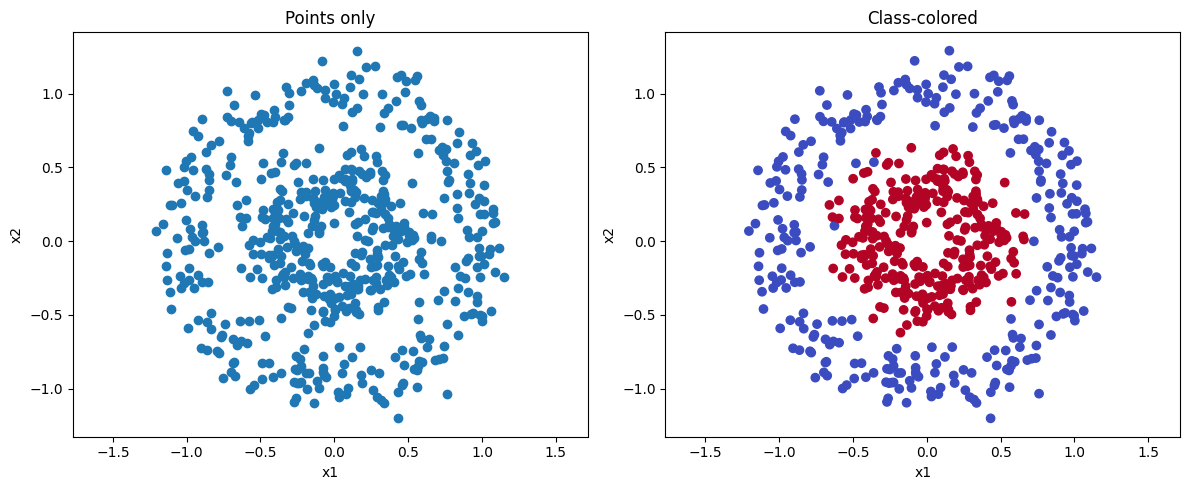

In [9]:
# Veri doğrusal değil (çember), ama biz doğrusal model kullanıyoruz -> underfit
# =========================================================
X2, y2 = make_circles(n_samples=600, noise=0.12, factor=0.4, random_state=42)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.35, random_state=42, stratify=y2
)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# c: genelde sayısal veya sınıf etiketleri verip cmap ile renk haritasına göre (colormap) boyamak için kullanılır. 
# Örn. c=y ile her nokta sınıfına göre renklenir.
# color: açıkça bir renk (veya renk listesi) belirtir; sayısal değerleri colormap ile eşlemeye çalışmaz. 
# Örn. color="gray" tüm noktaları gri yapar.
# Genelde “veriye göre renk” istiyorsanız c, “hepsi tek renk/explicit renkler” istiyorsanız color kullanın.
axs[0].scatter(X2[:, 0], X2[:, 1])
axs[0].set_title("Points only")
axs[0].set_xlabel("x1"); axs[1].set_ylabel("x2")
axs[0].axis("equal")

axs[1].scatter(X2[:, 0], X2[:, 1], c=y2, cmap="coolwarm")
axs[1].set_title("Class-colored")
axs[1].set_xlabel("x1"); axs[0].set_ylabel("x2")
axs[1].axis("equal")


fig.tight_layout()
plt.show()


In [10]:

# Underfit model: düz Logistic Regression (lineer karar sınırı)
underfit_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, random_state=42))
])

report("UNDERFIT (Kötü): Lineer LogisticRegression (çember veride)",
       underfit_model, X2_train, X2_test, y2_train, y2_test)



--- UNDERFIT (Kötü): Lineer LogisticRegression (çember veride) ---
Train acc: 0.510
Test  acc: 0.476


In [15]:
# Underfit'i düzeltecek aksiyonlar:
# A) Modele kapasite ekle: polynomial features
fixed_underfit_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, random_state=42))
])
report("UNDERFIT (Düzeldi): PolynomialFeatures(deg=3) + LogisticRegression",
       fixed_underfit_poly, X2_train, X2_test, y2_train, y2_test)



--- UNDERFIT (Düzeldi): PolynomialFeatures(deg=3) + LogisticRegression ---
Train acc: 0.995
Test  acc: 0.990


In [16]:

# B) Alternatif: Doğrusal olmayan bir model (RBF SVM)
fixed_underfit_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=5.0, gamma="scale", random_state=42))
])
report("UNDERFIT (Düzeldi - alternatif): RBF SVM (C=5)",
       fixed_underfit_svm, X2_train, X2_test, y2_train, y2_test)


--- UNDERFIT (Düzeldi - alternatif): RBF SVM (C=5) ---
Train acc: 0.992
Test  acc: 0.990
